Converting to single format and training a single model for the same.

In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import recall_score, accuracy_score, log_loss
import tensorflow as tf

# Define paths
combined_dir = 'D:/PKG - C-NMC 2019/C-NMC_combined_data'

# Parameters
img_width, img_height = 150, 150
batch_size = 32
epochs = 10

# Data Generators
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.1,  # 10% for validation (test)
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

def create_data_generators(combined_dir, img_width, img_height, batch_size):
    train_generator = datagen.flow_from_directory(
        combined_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',
        color_mode='rgb',  # Use RGB mode
        subset='training'  # 90% for training
    )
    test_generator = datagen.flow_from_directory(
        combined_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',
        color_mode='rgb',  # Use RGB mode
        subset='validation'  # 10% for testing
    )
    return train_generator, test_generator

train_generator, test_generator = create_data_generators(combined_dir, img_width, img_height, batch_size)


Found 9596 images belonging to 2 classes.
Found 1065 images belonging to 2 classes.


In [22]:
# Define the ResNet50 model
def build_resnet50():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs=base_model.input, outputs=predictions)
    
    # Freeze the convolutional base
    for layer in base_model.layers:
        layer.trainable = False
    
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Build the ResNet50 model for RGB images
resnet50_rgb = build_resnet50()


NameError: name 'train_data' is not defined

In [17]:
# Train the model
print("Training with combined dataset")
history = resnet50_rgb.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)


Training with combined dataset
Epoch 1/10
299/299 [==============================] - 598s 2s/step - loss: 0.6521 - accuracy: 0.6602 - val_loss: 0.6362 - val_accuracy: 0.6818
Epoch 2/10
299/299 [==============================] - 719s 2s/step - loss: 0.6287 - accuracy: 0.6819 - val_loss: 0.6234 - val_accuracy: 0.6828
Epoch 3/10
299/299 [==============================] - 628s 2s/step - loss: 0.6296 - accuracy: 0.6822 - val_loss: 0.6235 - val_accuracy: 0.6818
Epoch 4/10
299/299 [==============================] - 468s 2s/step - loss: 0.6288 - accuracy: 0.6825 - val_loss: 0.6228 - val_accuracy: 0.6828
Epoch 5/10
299/299 [==============================] - 444s 1s/step - loss: 0.6274 - accuracy: 0.6819 - val_loss: 0.6216 - val_accuracy: 0.6837
Epoch 6/10
299/299 [==============================] - 495s 2s/step - loss: 0.6278 - accuracy: 0.6821 - val_loss: 0.6268 - val_accuracy: 0.6837
Epoch 7/10
299/299 [==============================] - 494s 2s/step - loss: 0.6277 - accuracy: 0.6826 - val_loss

In [19]:
def evaluate_model(model, generator):
    # Get true labels
    y_true = generator.classes
    
    # Predict probabilities
    y_pred_prob = model.predict(generator, steps=generator.samples // batch_size + 1)  # Ensure all data is processed
    
    # Convert probabilities to binary predictions
    y_pred_binary = np.round(y_pred_prob).flatten()
    
    # Ensure the predicted binary labels match the number of true labels
    if len(y_true) != len(y_pred_binary):
        raise ValueError("Number of true labels and predicted labels do not match.")
    
    # Calculate recall, accuracy, and loss
    recall = recall_score(y_true, y_pred_binary)
    accuracy = accuracy_score(y_true, y_pred_binary)
    loss = log_loss(y_true, y_pred_prob)
    
    return recall, accuracy, loss

# Evaluate the model on the test data
print("Evaluating the model on the test data")
recall, accuracy, loss = evaluate_model(resnet50_rgb, test_generator)
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Loss: {loss:.4f}")

# Save the model
resnet50_rgb.save('resnet50_rgb.h5')
print("Model saved as resnet50_rgb.h5")


Evaluating the model on the test data
34/34 [==============================] - 68s 2s/step
Recall: 0.0000
Accuracy: 0.6826
Loss: 0.6253
Model saved as resnet50_rgb.h5


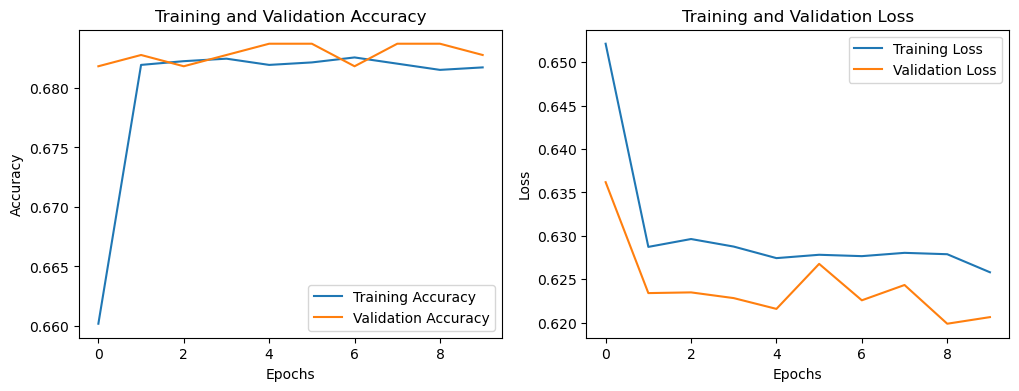

In [20]:
# Plot training & validation accuracy and loss values
def plot_model_performance(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

# Plot performance metrics
plot_model_performance(history)


Completed the entire process with purely one folder

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import recall_score, accuracy_score, log_loss
import tensorflow as tf


In [24]:
# Define paths
combined_dir = 'D:/PKG - C-NMC 2019/C-NMC_combined_data'

# Parameters
img_width, img_height = 150, 150
batch_size = 32
epochs = 10


In [25]:
# Data Generators
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.1,  # 10% for validation (test)
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

def create_data_generators(combined_dir, img_width, img_height, batch_size):
    train_generator = datagen.flow_from_directory(
        combined_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',
        color_mode='rgb',  # Use RGB mode
        subset='training'  # 90% for training
    )
    test_generator = datagen.flow_from_directory(
        combined_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',
        color_mode='rgb',  # Use RGB mode
        subset='validation'  # 10% for testing
    )
    return train_generator, test_generator

train_generator, test_generator = create_data_generators(combined_dir, img_width, img_height, batch_size)


Found 9596 images belonging to 2 classes.
Found 1065 images belonging to 2 classes.


In [26]:
def build_resnet50():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs=base_model.input, outputs=predictions)
    
    # Freeze all layers
    for layer in base_model.layers:
        layer.trainable = False
    
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [27]:
def fine_tune_resnet50(model, base_model):
    # Unfreeze the top layers
    for layer in base_model.layers:
        if 'conv5' in layer.name:  # Unfreeze layers from 'conv5' onwards
            layer.trainable = True
    
    model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# Build the ResNet50 model
resnet50_rgb = build_resnet50()

# Train the model
history = resnet50_rgb.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator
)


In [29]:

# Fine-tune the model
resnet50_rgb = fine_tune_resnet50(resnet50_rgb, ResNet50(weights='imagenet', include_top=False))

# Continue training with fine-tuned layers
history_fine_tune = resnet50_rgb.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator
)


c:\Users\chann\.conda\envs\tensorflow_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
300/300 [==============================] - 648s 2s/step - loss: 0.6293 - accuracy: 0.6821 - val_loss: 0.6246 - val_accuracy: 0.6826
Epoch 2/10
300/300 [==============================] - 612s 2s/step - loss: 0.6279 - accuracy: 0.6821 - val_loss: 0.6238 - val_accuracy: 0.6826
Epoch 3/10
217/300 [====================>.........] - ETA: 2:26 - loss: 0.6265 - accuracy: 0.6827

KeyboardInterrupt: 

In [ ]:
def evaluate_model(model, generator, batch_size):
    # Get true labels
    y_true = generator.classes

    # Predict probabilities
    y_pred_prob = model.predict(generator, steps=generator.samples // batch_size + 1, verbose=1)  # Ensure all data is processed

    # Convert probabilities to binary predictions
    y_pred_binary = np.round(y_pred_prob).flatten()

    # Ensure the predicted binary labels match the number of true labels
    if len(y_true) != len(y_pred_binary):
        raise ValueError("Number of true labels and predicted labels do not match.")

    # Calculate recall, accuracy, and loss
    recall = recall_score(y_true, y_pred_binary)
    accuracy = accuracy_score(y_true, y_pred_binary)
    loss = log_loss(y_true, y_pred_prob)

    return recall, accuracy, loss


In [ ]:
def plot_model_performance(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()


In [ ]:
# Evaluate the model on the test data
print("Evaluating the model on the test data")
recall, accuracy, loss = evaluate_model(resnet50_rgb, test_generator, batch_size)
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Loss: {loss:.4f}")

# Save the model
resnet50_rgb.save('resnet50_rgb.h5')
print("Model saved as resnet50_rgb.h5")

# Plot performance metrics
plot_model_performance(history)
